ipython notebook 是一个便于使用的浏览器内 python 交互界面。现在改名为 Jupyter。

在命令行下输入 `ipython notebook` 就可以打开当前文件夹，下面的 `*.ipynb` 就是一个 ipython 笔记本。

远程使用 Jupyter Notebook （iPython Notebook）可以参考我的博客：
[远程使用 Jupyter Notebook （iPython Notebook）](http://tangzx.qiniudn.com/post-0109-remote-jupyter.html)。

# 使用 notebook 前的说明

-   在运行前可以先看看之前的运行结果；
-   然后清除所有的 cell output，自己运行一遍
-   不要忘了，即使是在浏览器里，是 ipython 都有代码提示的
-   之前老是不知道 cell 运行完没有，就加了很多 `print "done"`，后来发现，运行后，cell 左侧
    的 `In [2]` 会变成 `In [*]`，运行完了后会变回去（编号可能会变）。你可以 control-enter 让
    几个 cell 都计划运行，全部运行完了它们才会同时输出结果。

# Instant Recognition with Caffe

In this example we'll classify an image with the bundled CaffeNet model based on the network architecture of Krizhevsky et al. for ImageNet. We'll compare CPU and GPU operation then reach into the model to inspect features and the output.

(These feature visualizations follow the DeCAF visualizations originally by Yangqing Jia.)

First, import required modules, set plotting parameters, and run `./scripts/download_model_binary.py models/bvlc_reference_caffenet` to get the pretrained CaffeNet model if it hasn't already been fetched.

In [2]:
# 用迅雷下载更加快：http://dl.caffe.berkeleyvision.org/bvlc_reference_caffenet.caffemodel
# 下载后用 scp 传到服务器：scp bvlc_reference_caffenet.caffemodel tzx@192.168.1.106:~/datasets/
# 在 control-enter 运行这个 cell 前，把 model 文件拷贝到相应目录，这样就无需下载了
# cp $DATASETS_DIR/bvlc_reference_caffenet.caffemodel ~/dev/caffe-rc3/models/bvlc_reference_caffenet/

# 在公司服务器上我家目录下（/home/tzx/datasets/datasets/） 文件夹下有我已经下载好了的数据（models，images，etc），
# 我会 occasionally 同步（rsync）到 /media/swoda/0008E29D0001936B/Downloads/datasets

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import os
if not os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print("Downloading pre-trained CaffeNet model...")
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet
else:
    print "已经有文件，无需下载。"

print "done."

已经有文件，无需下载。
done.


Set Caffe to CPU mode, load the net in the test phase for inference, and configure input preprocessing.

In [3]:
caffe.set_mode_cpu()
net = caffe.Net(caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt',
                caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel',
                caffe.TEST)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB
print "done"

done


上面的 `deploy.prototxt` 是定义的网络结构，caffe 的网络结构设置可以参考：[Caffe | Layer Catalogue](http://caffe.berkeleyvision.org/tutorial/layers.html)。

`bvlc_reference_caffenet.caffemodel` 则是已经训练好的模型，直接拿来用，模型是用上面的
`!../scripts/download_model_binary.py ../models/bvlc_reference_caffenet` 下载到的
（当然我是用迅雷下载了 scp 到服务器的）。Caffe 官网还提供很多模型的下载，参见
[Model Zoo · BVLC/caffe Wiki](https://github.com/BVLC/caffe/wiki/Model-Zoo)。

Let's start with a simple classification. We'll set a batch of 50 to demonstrate batch processing, even though we'll only be classifying one image. (Note that the batch size can also be changed on-the-fly.)

In [4]:
# set net to batch size of 50
net.blobs['data'].reshape(50,3,227,227)
print "done"

print net

net?
print net.blobs['data']
print net.blobs['data'].shape

done


因为是 ipython，所以可以查看帮助，比如 `net?`，想看更详细的帮助，用 `net??`。
帮助窗口会出现在下方。别忘了 `TAB` 键可以补全。

Feed in the image (with some preprocessing) and classify with a forward pass.

In [5]:
net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(caffe_root + 'examples/images/cat.jpg'))
out = net.forward()
print("Predicted class is #{}.".format(out['prob'][0].argmax()))

print transformer
print "done"

Predicted class is #281.
<caffe.io.Transformer instance at 0x7fa31d8b3cf8>
done


In [7]:
print net.forward

<bound method Net._Net_forward of <caffe._caffe.Net object at 0x7f03abe9b578>>


What did the input look like?

50

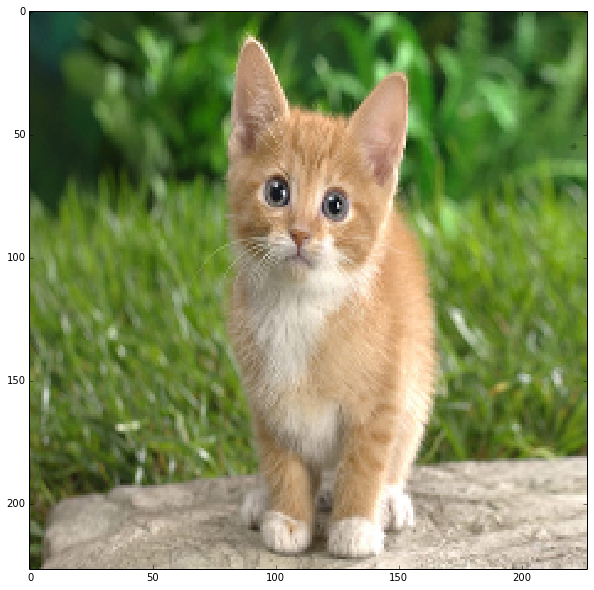

In [6]:
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[39]))
len(net.blobs['data'].data)

一只小猫（恐怖的生物）！

比起 ssh 连接远程服务器，notebook 的好处是有图形界面。可以把结果图片（当然这里还不是结果）显示出来。
ipython notebook (jupyter) 牛逼就在这里。

Adorable, but was our classification correct?

In [7]:
# load labels
imagenet_labels_filename = caffe_root + 'data/ilsvrc12/synset_words.txt'
try:
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
except:
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')

# sort top k predictions from softmax output
top_k = net.blobs['prob'].data[0].flatten().argsort()[-1:-6:-1]
print labels[top_k]

['n02123045 tabby, tabby cat' 'n02123159 tiger cat'
 'n02124075 Egyptian cat' 'n02119022 red fox, Vulpes vulpes'
 'n02127052 lynx, catamount']


Indeed! But how long did it take?

In [8]:
# CPU mode
net.forward()  # call once for allocation
%timeit net.forward()
# timeit 就是 ipython 提供的 magic 函数之一

1 loop, best of 3: 4.52 s per loop


That's a while, even for a batch size of 50 images. Let's switch to GPU mode.

In [9]:
# GPU mode
caffe.set_device(0)
caffe.set_mode_gpu()
net.forward()  # call once for allocation
%timeit net.forward()

10 loops, best of 3: 38.7 ms per loop


可以看到性能提升是明显的：

-   CPU: 1 loop, best of 3: 4.7 s per loop
-   GPU: 10 loops, best of 3: 56.1 ms per loop
        
有一百倍的性能提升。

Much better. Now let's look at the net in more detail.

First, the layer features and their shapes (1 is the batch size, corresponding to the single input image in this example).

In [10]:
print "type of net.blobs: ", type(net.blobs)

[(k, v.data.shape) for k, v in net.blobs.items()]

type of net.blobs:  <class 'collections.OrderedDict'>


[('data', (50, 3, 227, 227)),
 ('conv1', (50, 96, 55, 55)),
 ('pool1', (50, 96, 27, 27)),
 ('norm1', (50, 96, 27, 27)),
 ('conv2', (50, 256, 27, 27)),
 ('pool2', (50, 256, 13, 13)),
 ('norm2', (50, 256, 13, 13)),
 ('conv3', (50, 384, 13, 13)),
 ('conv4', (50, 384, 13, 13)),
 ('conv5', (50, 256, 13, 13)),
 ('pool5', (50, 256, 6, 6)),
 ('fc6', (50, 4096)),
 ('fc7', (50, 4096)),
 ('fc8', (50, 1000)),
 ('prob', (50, 1000))]

说说上面，用 `type(net.blobs)` 查看 blobs 的数据类型，可知它是 `<class 'collections.OrderedDict'>`，
其实就是排序了的 key value pairs（键值对）。key 是 feature，它的 value 里包含这个 feature 的 shape（`value.data.shape`）。

blobs 存储了网络结构，一个 feature 对应一层（和 GIS 里的 feature 差不多意思，就是一个“图层”什么的。）

虽然这里**从上往下**是 data, conv1, ..., fc6, ..., prob，但是 caffe 的 layer 结构定义的时候其实是
**从下往上**，比如 conv1，它的 `bottom` 是 data，它的 `top` 是 conv1
（它只管知道数据从哪里获取，进行如何如何的处理，它不关心自己的处理结果交给谁。
所以 top 的定义其实不是“传给谁”，而是“传出去”。）

再看下面。

The parameters and their shapes. The parameters are `net.params['name'][0]` while biases are `net.params['name'][1]`.

不得不吐槽一下，这个蛋疼的规则……**第一个`[0]`对应参数，第二个`[1]`对应 bias。**

In [14]:
[(k, v[0].data.shape) for k, v in net.params.items()]

[('conv1', (96, 3, 11, 11)),
 ('conv2', (256, 48, 5, 5)),
 ('conv3', (384, 256, 3, 3)),
 ('conv4', (384, 192, 3, 3)),
 ('conv5', (256, 192, 3, 3)),
 ('fc6', (4096, 9216)),
 ('fc7', (4096, 4096)),
 ('fc8', (1000, 4096))]

In [15]:
net.params

OrderedDict([('conv1', <caffe._caffe.BlobVec at 0x7fa31e00c980>),
             ('conv2', <caffe._caffe.BlobVec at 0x7fa31e00cc90>),
             ('conv3', <caffe._caffe.BlobVec at 0x7fa31e00c7c0>),
             ('conv4', <caffe._caffe.BlobVec at 0x7fa31e00ca60>),
             ('conv5', <caffe._caffe.BlobVec at 0x7fa31e00c600>),
             ('fc6', <caffe._caffe.BlobVec at 0x7fa31e00c670>),
             ('fc7', <caffe._caffe.BlobVec at 0x7fa31e00c910>),
             ('fc8', <caffe._caffe.BlobVec at 0x7fa31e00c9f0>)])

In [21]:
print caffe._caffe.BlobVec
caffe._caffe.BlobVec??

<class 'caffe._caffe.BlobVec'>


caffe._caffe.BlobVec??

```
Docstring:      <no docstring>
Init docstring:
__init__( (object)arg1) -> None :

    C++ signature :
        void __init__(_object*)
File:           ~/dev/caffe-rc3/python/caffe/_caffe.so
Type:           class
```

In [17]:
print net.params.items == net.params
net.params.items?
net.params?

False


我把上面弹出的帮助信息放在这里：

### `net.params.items?`

```
Signature: net.params.items()
Docstring: od.items() -> list of (key, value) pairs in od
File:      /usr/lib/python2.7/collections.py
Type:      instancemethod
```

### `net.params?`

```
Type:        property
String form: <property object at 0x7fdac302b3c0>
Docstring:
An OrderedDict (bottom to top, i.e., input to output) of network
parameters indexed by name; each is a list of multiple blobs (e.g.,
weights and biases)
```

看上去都是用的 python 原生的数据结构。

Helper functions for visualization

In [22]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

这个用来显示数据（filter 什么的）的 helper 函数好难理解
（一方面是对 python 的 slicing 不熟悉，一方面对这个 caffe 网络结构不熟）。
先跳过。

The input image

The first layer filters, `conv1`

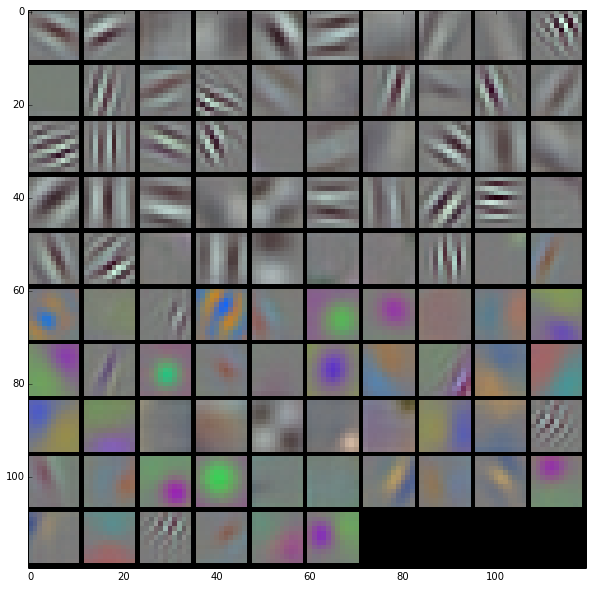

In [23]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

The first layer output, `conv1` (rectified responses of the filters above, first 36 only)

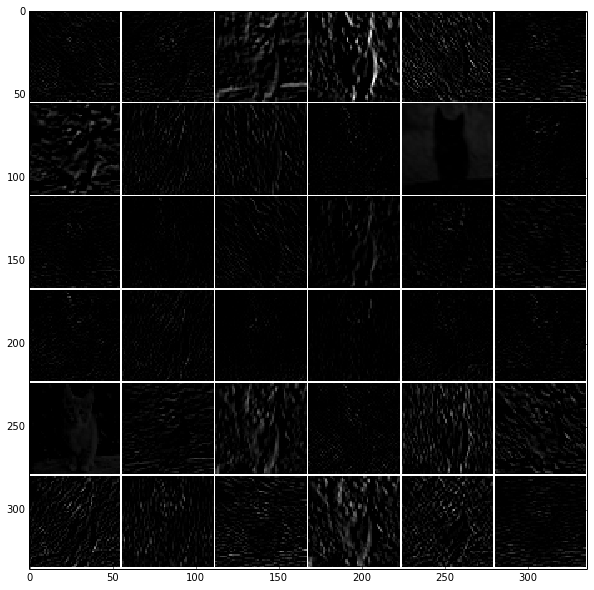

In [24]:
feat = net.blobs['conv1'].data[0, :36]
vis_square(feat, padval=1)

The second layer filters, `conv2`

There are 256 filters, each of which has dimension 5 x 5 x 48. We show only the first 48 filters, with each channel shown separately, so that each filter is a row.

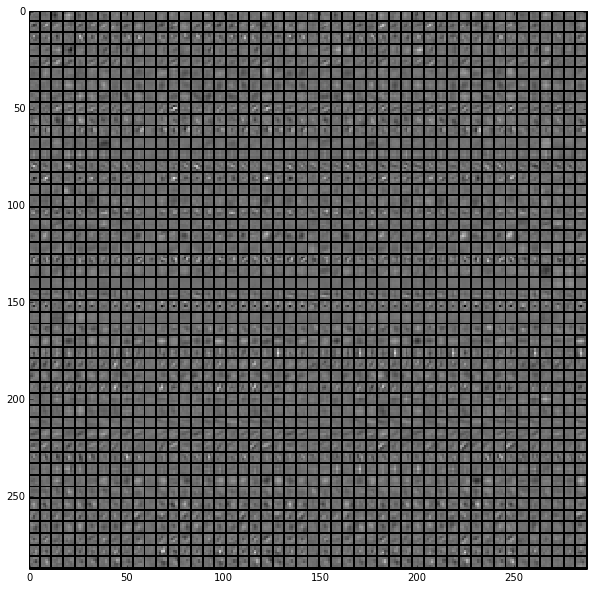

In [25]:
filters = net.params['conv2'][0].data
vis_square(filters[:48].reshape(48**2, 5, 5))

The second layer output, `conv2` (rectified, only the first 36 of 256 channels)

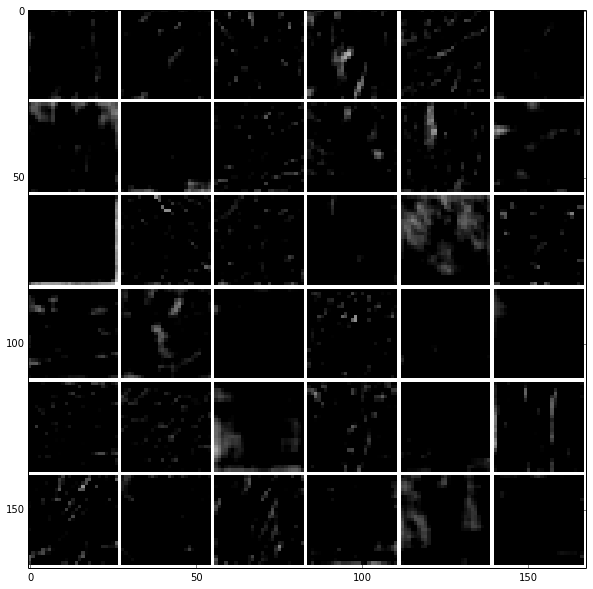

In [26]:
feat = net.blobs['conv2'].data[0, :36]
vis_square(feat, padval=1)

The third layer output, `conv3` (rectified, all 384 channels)

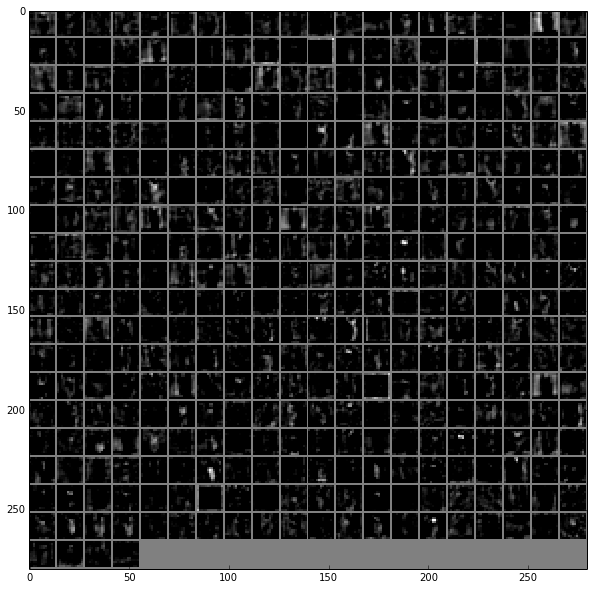

In [27]:
feat = net.blobs['conv3'].data[0]
vis_square(feat, padval=0.5)

The fourth layer output, `conv4` (rectified, all 384 channels)

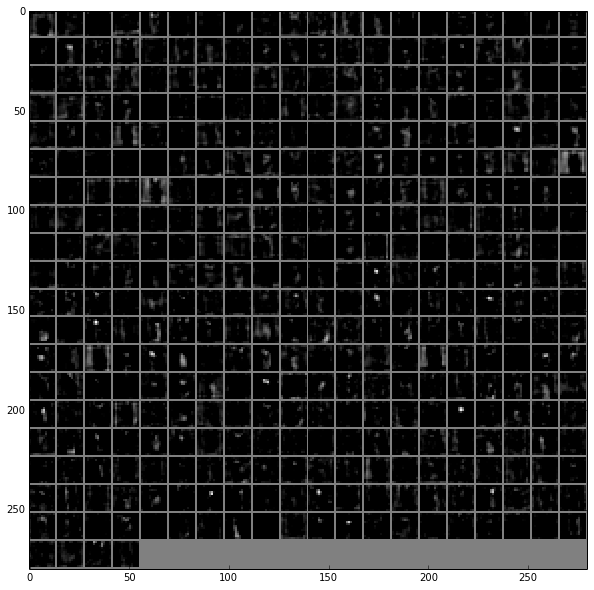

In [30]:
feat = net.blobs['conv4'].data[0]
vis_square(feat, padval=0.5)

上面那个 cell 里，第一行如果加上 `%%timeit`，就可以对整个 cell 计时。这样的话，图片不会显示出来，会有如下输出：

```
The slowest run took 26.24 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 1.02 ms per loop
```

The fifth layer output, `conv5` (rectified, all 256 channels)

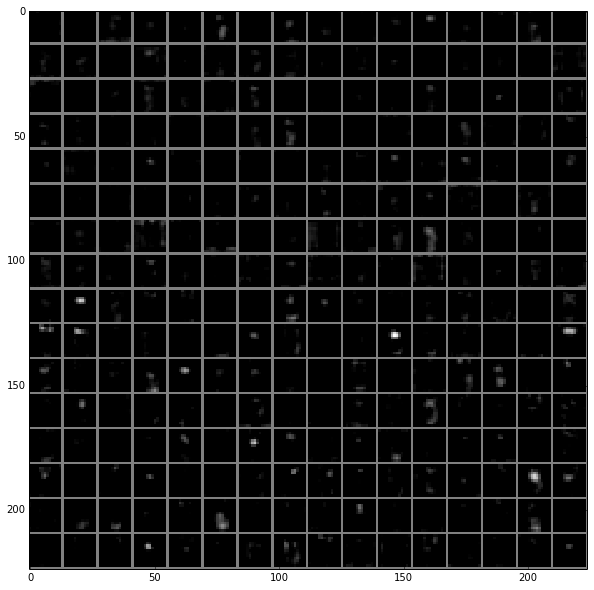

In [31]:
feat = net.blobs['conv5'].data[0]
vis_square(feat, padval=0.5)

The fifth layer after pooling, `pool5`

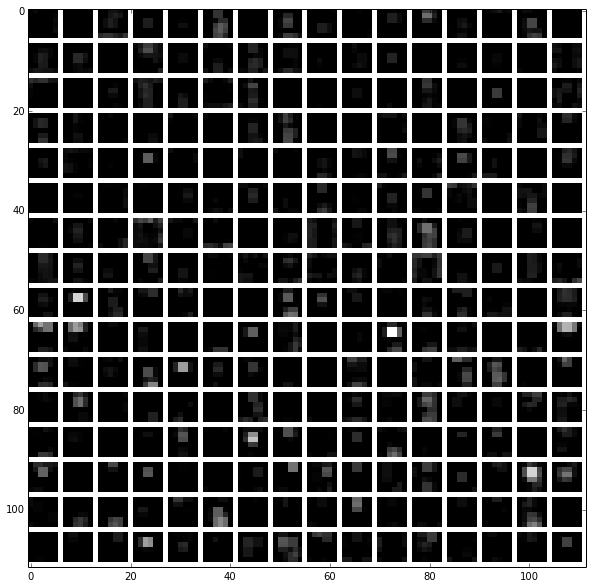

In [32]:
feat = net.blobs['pool5'].data[0]
vis_square(feat, padval=1)

The first fully connected layer, `fc6` (rectified)

We show the output values and the histogram of the positive values

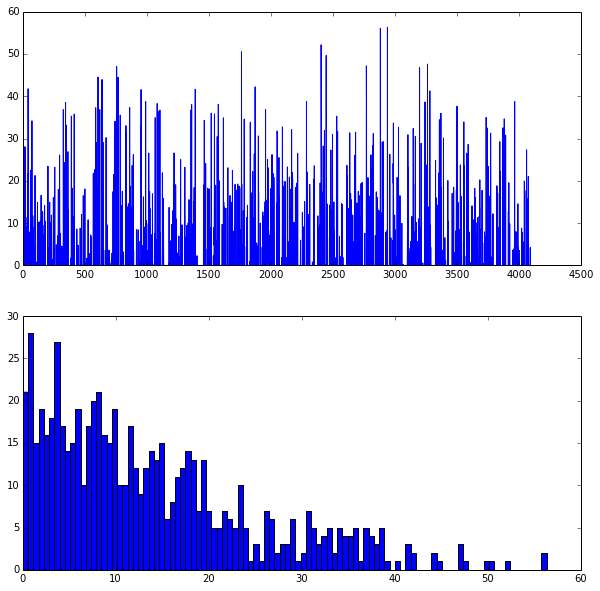

In [33]:
feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

The second fully connected layer, `fc7` (rectified)

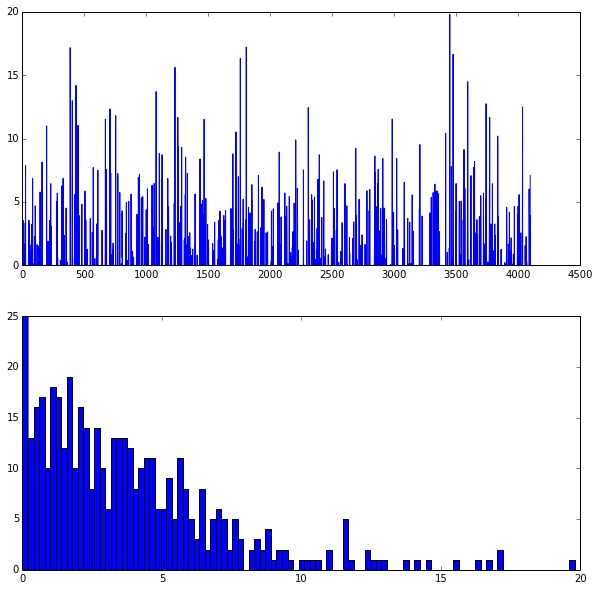

In [34]:
feat = net.blobs['fc7'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

The final probability output, `prob`

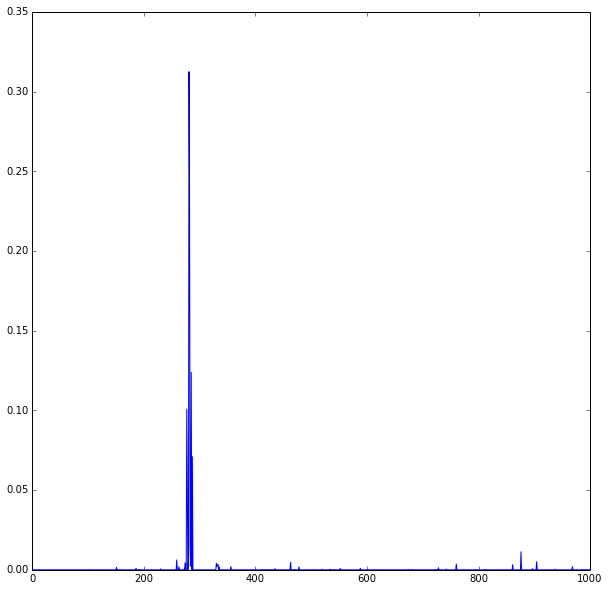

In [35]:
feat = net.blobs['prob'].data[0]
plt.plot(feat.flat)

Let's see the top 5 predicted labels.

In [38]:
# load labels
imagenet_labels_filename = caffe_root + 'data/ilsvrc12/synset_words.txt'
try:
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
except:
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')

# sort top k predictions from softmax output
top_k = net.blobs['prob'].data[0].flatten().argsort()[-1:-6:-1]
print labels[top_k]

['n02123045 tabby, tabby cat' 'n02123159 tiger cat'
 'n02124075 Egyptian cat' 'n02119022 red fox, Vulpes vulpes'
 'n02127052 lynx, catamount']
